In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name, parse_dates=['Date'])
df.set_index('Date', inplace=True)

Saving horticulture_prices.csv to horticulture_prices (2).csv


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.2 MB/s eta 0:00:00


In [ ]:
df = df.sort_index()

In [ ]:
target_col = df.columns[0]
data = df[[target_col]]

In [ ]:
data = data[pd.to_numeric(data[target_col], errors='coerce').notnull()]
data = data.astype(float)

<Axes: title={'center': 'Original Price Data'}, xlabel='Date'>

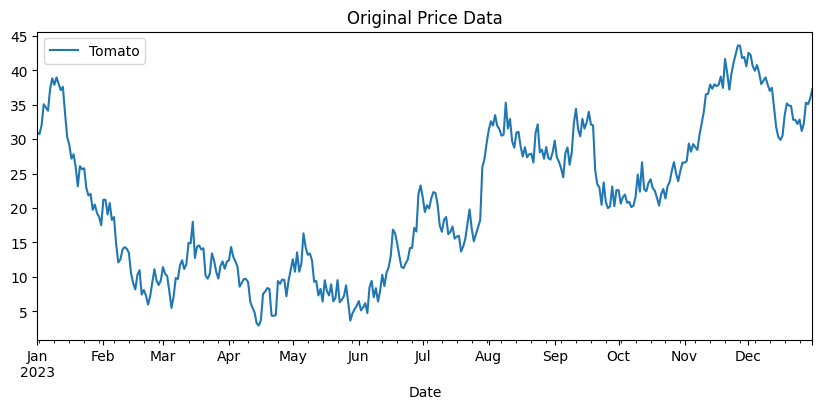

In [ ]:
data.plot(title="Original Price Data", figsize=(10,4))


In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

In [ ]:
def create_rnn_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 7
X_rnn, y_rnn = create_rnn_sequences(scaled, seq_len)

In [ ]:
model_rnn = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, 1)),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_rnn, y_rnn, epochs=30, batch_size=8, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
last_seq = scaled[-seq_len:]
pred_rnn = []

for _ in range(31):
    pred = model_rnn.predict(last_seq.reshape(1, seq_len, 1), verbose=0)
    pred_rnn.append(pred[0, 0])
    last_seq = np.append(last_seq[1:], [[pred[0, 0]]], axis=0)

rnn_forecast = scaler.inverse_transform(np.array(pred_rnn).reshape(-1, 1))

In [ ]:
X_bp = []
y_bp = []
window = 7
for i in range(len(data) - window):
    X_bp.append(data.values[i:i+window].flatten())
    y_bp.append(data.values[i+window][0])
X_bp, y_bp = np.array(X_bp), np.array(y_bp)

bp_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000)
bp_model.fit(X_bp, y_bp)

MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000)

In [ ]:
X_last_bp = data.values[-window:].flatten().reshape(1, -1)
bp_preds = []
for _ in range(31):
    pred = bp_model.predict(X_last_bp)[0]
    bp_preds.append(pred)
    X_last_bp = np.roll(X_last_bp, -1)
    X_last_bp[0, -1] = pred

In [ ]:
start_date = pd.to_datetime('2025-05-01')
forecast_dates = pd.date_range(start=start_date, periods=31, freq='D')

combined = pd.DataFrame({
    'Date': forecast_dates,
    'RNN': rnn_forecast.flatten(),
    'BP': bp_preds
})
combined.set_index('Date', inplace=True)

In [ ]:
print("\n📊 Price Predictions for May 2025:\n")
print(combined)


📊 Price Predictions for May 2025:

                  RNN         BP
Date                            
2025-05-01  36.329670  36.978964
2025-05-02  36.501076  37.114750
2025-05-03  36.374001  37.438795
2025-05-04  36.072380  37.374734
2025-05-05  35.808090  37.404680
2025-05-06  35.455421  37.510587
2025-05-07  35.094681  37.403650
2025-05-08  34.763039  37.357321
2025-05-09  34.397598  37.324593
2025-05-10  34.049793  37.243035
2025-05-11  33.712013  37.169788
2025-05-12  33.383926  37.108110
2025-05-13  33.070621  37.019200
2025-05-14  32.770226  36.940143
2025-05-15  32.483494  36.862262
2025-05-16  32.211487  36.779675
2025-05-17  31.952250  36.698645
2025-05-18  31.705139  36.620546
2025-05-19  31.470116  36.539904
2025-05-20  31.246386  36.461925
2025-05-21  31.033476  36.385032
2025-05-22  30.830172  36.308839
2025-05-23  30.635920  36.233912
2025-05-24  30.450453  36.160590
2025-05-25  30.273249  36.088041
2025-05-26  30.103907  36.017013
2025-05-27  29.942066  35.947201
2025-05

In [ ]:
combined.to_csv("may2025_predictions.csv")
files.download("may2025_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

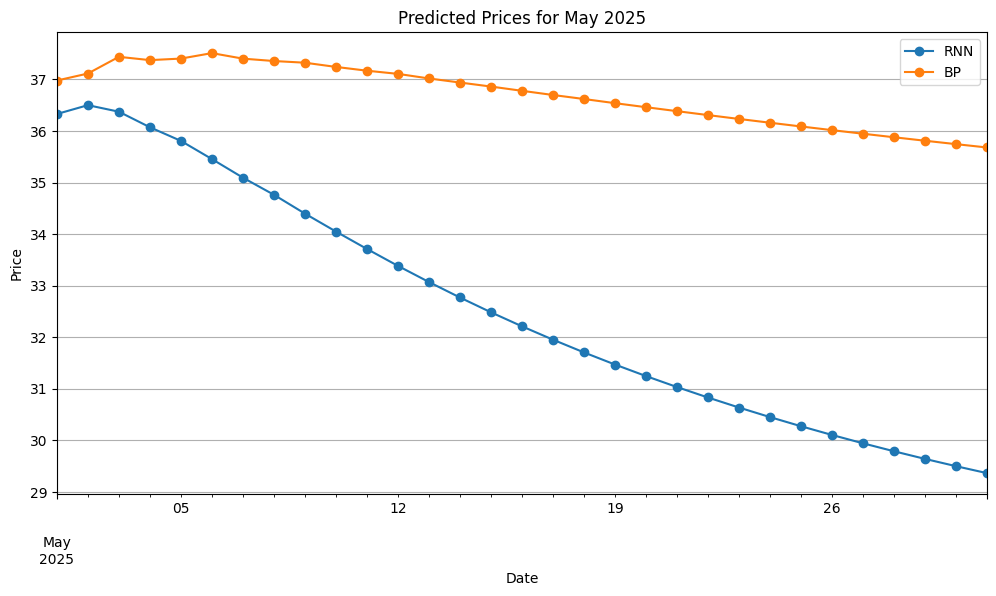

In [ ]:
combined.plot(title='Predicted Prices for May 2025', figsize=(12, 6), marker='o')
plt.ylabel('Price')
plt.grid(True)
plt.show()